<a href="https://colab.research.google.com/github/mlacasa/EstadisticaQ2/blob/main/SurvivalAnalysisColon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BASE DE DATOS CÁNCER DE COLON PARA UN ANÁLISIS DE SUPERVIVENCIA

In [1]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=d7e593b1fe3fb84be625e6f73ec6e5114872ef306527d0fb36b1154f18ed89cd
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Configuración estética
#plt.style.use('seaborn')
sns.set_palette("husl")

# 1. Cargar datos y mostrar primeras filas
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Unir/healthcare/colon.csv")
print("Primeras 5 filas del dataset:")
df.head()

Primeras 5 filas del dataset:


,time,status,study,rx,sex,age,obstruct,perfor,adhere,nodes,differ,extent,surg,node4,etype
0,8,1,1,3,0,32,0,0,0,14,3,2,0,1,1
1,9,1,1,3,1,55,1,0,0,5,3,3,0,1,1
2,19,1,1,1,1,59,1,0,0,2,2,3,1,0,1
3,20,1,1,2,1,66,1,0,0,4,2,3,0,0,1
4,23,0,1,3,0,52,0,0,0,3,3,3,1,0,1


In [25]:
# Seleccionar el paciente de la primera fila
primer_paciente = df.iloc[0]

# Imprimir la información del paciente en formato de columna
primer_paciente


,0
time,8
status,1
study,1
rx,3
sex,0
age,32
obstruct,0
perfor,0
adhere,0
nodes,14


In [26]:
df.describe()

,time,status,study,rx,sex,age,obstruct,perfor,adhere,nodes,differ,extent,surg,node4,etype
count,888.000000,888.000000,888.0,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,888.00000,888.0
mean,1410.355856,0.502252,1.0,1.994369,0.518018,59.810811,0.192568,0.030405,0.144144,3.663288,2.061937,2.884009,0.268018,0.26464,1.0
std,998.002952,0.500277,0.0,0.810703,0.499957,11.914493,0.394538,0.171797,0.351434,3.540126,0.510977,0.478457,0.443177,0.44139,0.0
min,8.000000,0.000000,1.0,1.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,1.0
25%,379.750000,0.000000,1.0,1.000000,0.000000,53.000000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000,0.00000,1.0
50%,1556.000000,1.000000,1.0,2.000000,1.000000,61.000000,0.000000,0.000000,0.000000,2.000000,2.000000,3.000000,0.000000,0.00000,1.0
75%,2289.750000,1.000000,1.0,3.000000,1.000000,69.000000,0.000000,0.000000,0.000000,5.000000,2.000000,3.000000,1.000000,1.00000,1.0
max,3329.000000,1.000000,1.0,3.000000,1.000000,85.000000,1.000000,1.000000,1.000000,33.000000,3.000000,4.000000,1.000000,1.00000,1.0


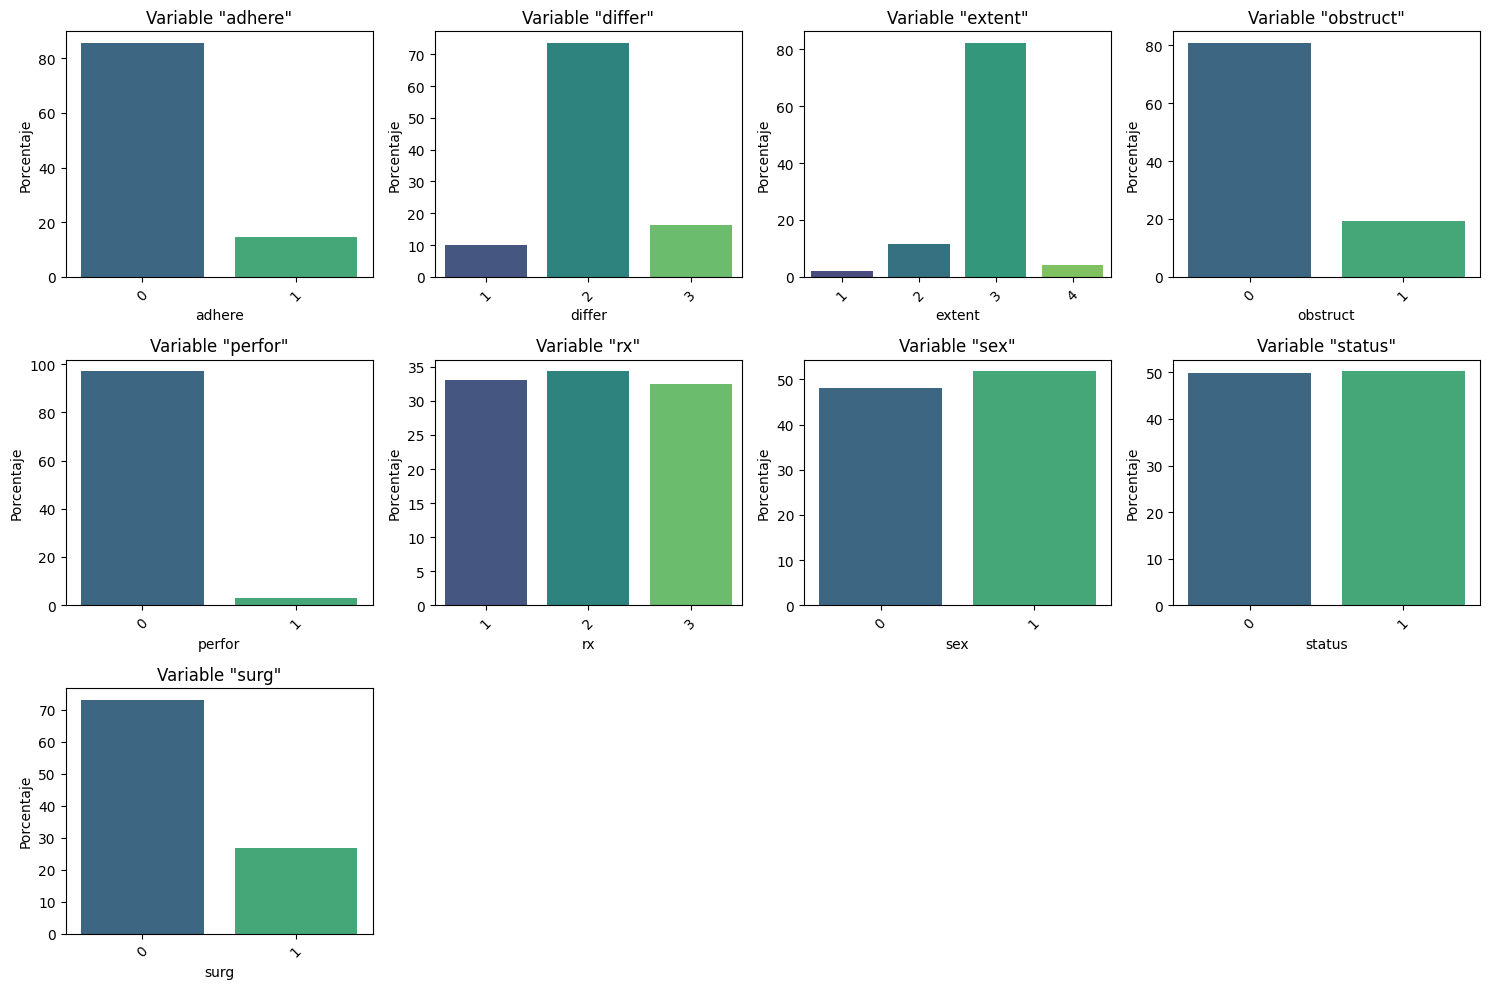

In [27]:
categorical_vars = ['adhere', 'differ', 'extent', 'obstruct', 'perfor', 'rx', 'sex', 'status', 'surg']

# Configuración de la gráfica
plt.figure(figsize=(15, 10))

for var in categorical_vars:
    # Calcular las proporciones
    counts = df[var].value_counts()
    proportions = counts / counts.sum() * 100

    # Crear el gráfico de barras
    plt.subplot(3, 4, categorical_vars.index(var) + 1) # 3 filas x 4 columnas
    sns.barplot(x=proportions.index, y=proportions.values, palette="viridis")

    # Configuración del gráfico
    plt.title(f'Variable "{var}"')
    plt.xlabel(var)
    plt.ylabel('Porcentaje')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## CURVA KAPLAN MEIER DE TODOS LOS PACIENTES

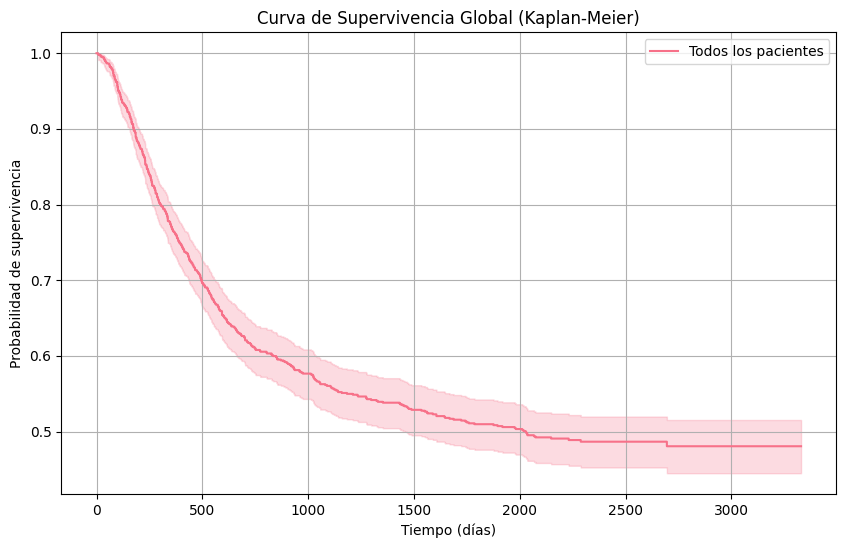

In [28]:
# 2. Análisis Kaplan-Meier global
kmf = KaplanMeierFitter()
kmf.fit(df['time'], df['status'], label='Todos los pacientes')
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=True)
plt.title('Curva de Supervivencia Global (Kaplan-Meier)')
plt.ylabel('Probabilidad de supervivencia')
plt.xlabel('Tiempo (días)')
plt.grid(True)
plt.show()

## ANÁLISIS POR EL GRUPO DE TRATAMIENTO

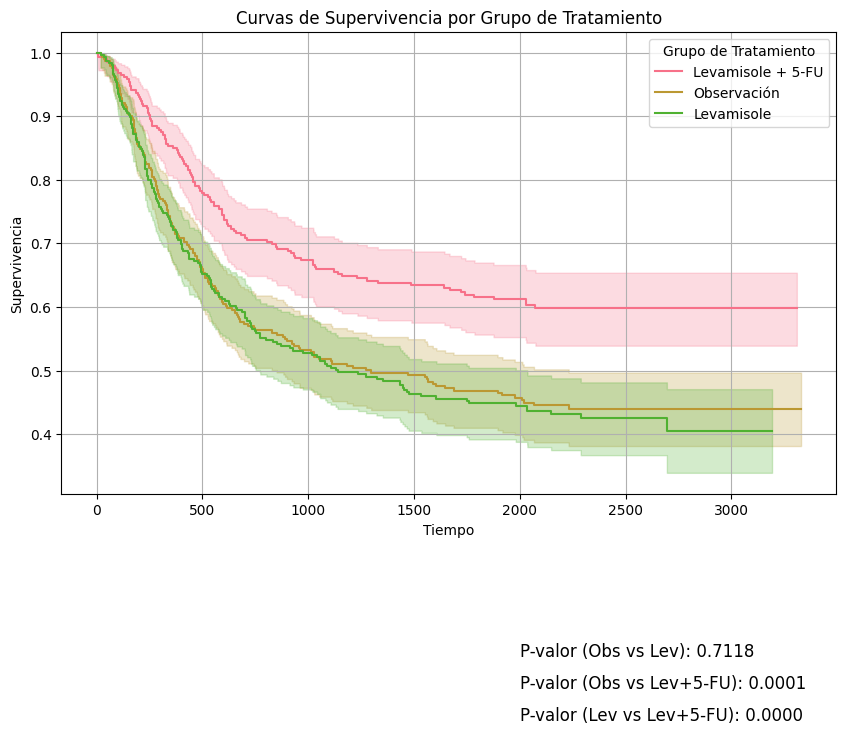

In [29]:
# Cambia los valores de 'rx' a sus etiquetas categóricas.
df['rx'] = df['rx'].map({1: 'Observación', 2: 'Levamisole', 3: 'Levamisole + 5-FU'})

# Crear una instancia del objeto KaplanMeierFitter
kmf = KaplanMeierFitter()

# Definir el gráfico
plt.figure(figsize=(10, 6))

# Crear un diccionario para almacenar los datos de tratamiento
treatment_data = {}

# Graficar las curvas de supervivencia para cada grupo de tratamiento
for treatment in df['rx'].unique():
    mask = df['rx'] == treatment
    kmf.fit(durations=df['time'][mask], event_observed=df['status'][mask], label=treatment)
    kmf.plot_survival_function()

    # Almacenar datos para el test log-rank
    treatment_data[treatment] = (df['time'][mask], df['status'][mask])

# Realizar el test log-rank entre los tratamientos
results = logrank_test(treatment_data['Observación'][0], treatment_data['Levamisole'][0],
                        event_observed_A=treatment_data['Observación'][1],
                        event_observed_B=treatment_data['Levamisole'][1])
p_value_1_2 = results.p_value

results = logrank_test(treatment_data['Observación'][0], treatment_data['Levamisole + 5-FU'][0],
                        event_observed_A=treatment_data['Observación'][1],
                        event_observed_B=treatment_data['Levamisole + 5-FU'][1])
p_value_1_3 = results.p_value

results = logrank_test(treatment_data['Levamisole'][0], treatment_data['Levamisole + 5-FU'][0],
                        event_observed_A=treatment_data['Levamisole'][1],
                        event_observed_B=treatment_data['Levamisole + 5-FU'][1])
p_value_2_3 = results.p_value

# Añadir los valores p al gráfico
y_position = 0.05  # posición y para los valores p en el gráfico
plt.text(2000, y_position, f'P-valor (Obs vs Lev): {p_value_1_2:.4f}', fontsize=12, color='black')
plt.text(2000, y_position - 0.05, f'P-valor (Obs vs Lev+5-FU): {p_value_1_3:.4f}', fontsize=12, color='black')
plt.text(2000, y_position - 0.10, f'P-valor (Lev vs Lev+5-FU): {p_value_2_3:.4f}', fontsize=12, color='black')

# Configurar el título y las leyendas
plt.title('Curvas de Supervivencia por Grupo de Tratamiento')
plt.xlabel('Tiempo')
plt.ylabel('Supervivencia')
plt.legend(title='Grupo de Tratamiento')
plt.grid()
plt.show()

## ANÁLISIS POR OTROS GRUPOS

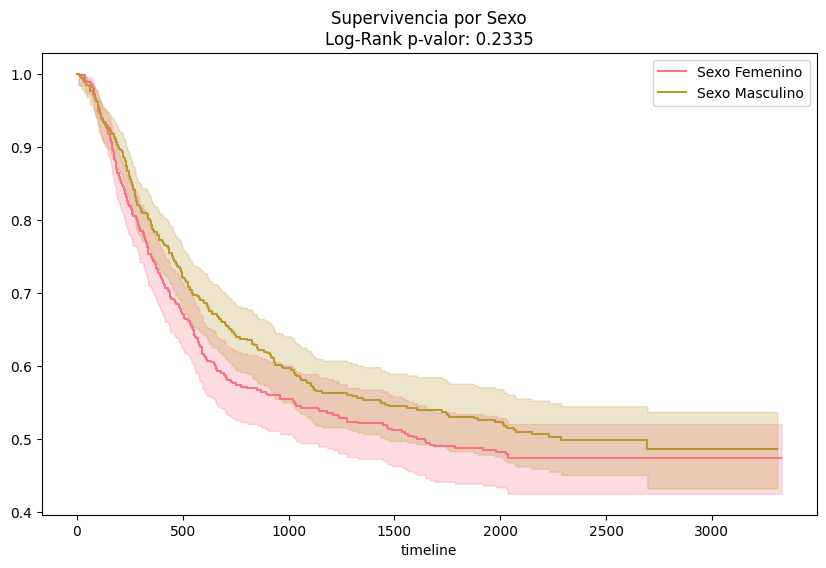

In [30]:
# 3. Log-Rank por sexo
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

for sex in [0, 1]:
    mask = df['sex'] == sex
    kmf.fit(df[mask]['time'], df[mask]['status'], label=f'Sexo {["Femenino", "Masculino"][sex]}')
    kmf.plot_survival_function(ax=ax)

# Test Log-Rank
result = logrank_test(df[df['sex']==0]['time'], df[df['sex']==1]['time'],
                      df[df['sex']==0]['status'], df[df['sex']==1]['status'])
plt.title(f'Supervivencia por Sexo\nLog-Rank p-valor: {result.p_value:.4f}')
plt.legend()
plt.show()

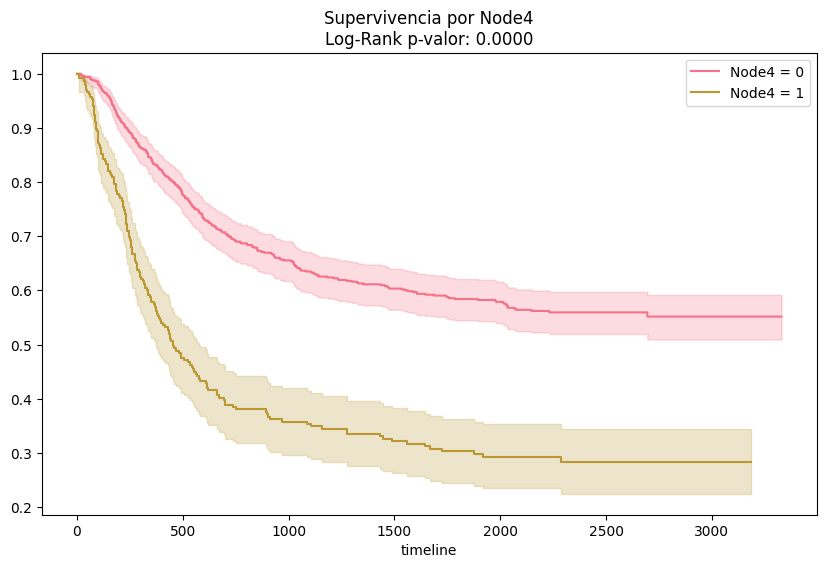

In [32]:
# 5. Análisis por node4
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

for n4 in [0, 1]:
    mask = df['node4'] == n4
    kmf.fit(df[mask]['time'], df[mask]['status'], label=f'Node4 = {n4}')
    kmf.plot_survival_function(ax=ax)

result = logrank_test(df[df['node4']==0]['time'], df[df['node4']==1]['time'],
                      df[df['node4']==0]['status'], df[df['node4']==1]['status'])
plt.title(f'Supervivencia por Node4\nLog-Rank p-valor: {result.p_value:.4f}')
plt.legend()
plt.show()

## ANÁLISIS DE LA FUNCIÓN DE COX

In [39]:
# 6. Análisis de Cox multivariable corregido (versión funcional)

# ----------------------------------------------------------
# Paso 1: Preparación de variables categóricas
# ----------------------------------------------------------
covariates = ['age', 'sex', 'obstruct', 'perfor', 'adhere', 'nodes',
             'differ', 'extent', 'surg', 'node4', 'etype', 'rx']  # Añadida 'rx'

# Convertir variables categóricas y eliminar NaN
df_cox = (
    df[covariates + ['time', 'status']]
    .dropna()
    .pipe(pd.get_dummies,
          columns=['differ', 'extent', 'etype', 'rx'],  # Incluir 'rx'
          drop_first=True)
)

# ----------------------------------------------------------
# Paso 2: Eliminar variables constantes manualmente
# ----------------------------------------------------------
# Verificar qué columnas tienen varianza casi cero
constant_cols = df_cox.columns[df_cox.nunique() == 1]
df_cox = df_cox.drop(columns=constant_cols)

# ----------------------------------------------------------
# Paso 3: Estandarizar variables numéricas
# ----------------------------------------------------------
from sklearn.preprocessing import StandardScaler
numeric_cols = ['age', 'nodes']
df_cox[numeric_cols] = StandardScaler().fit_transform(df_cox[numeric_cols])

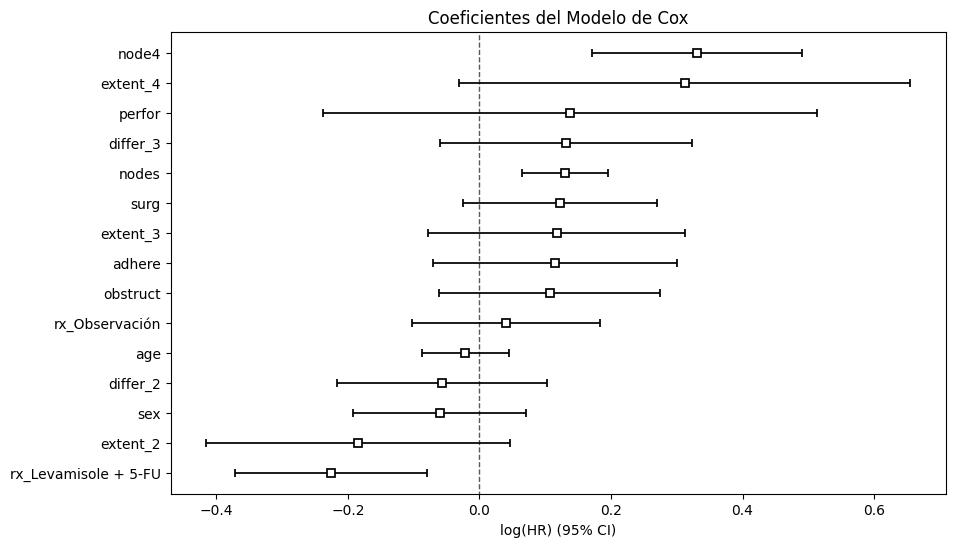

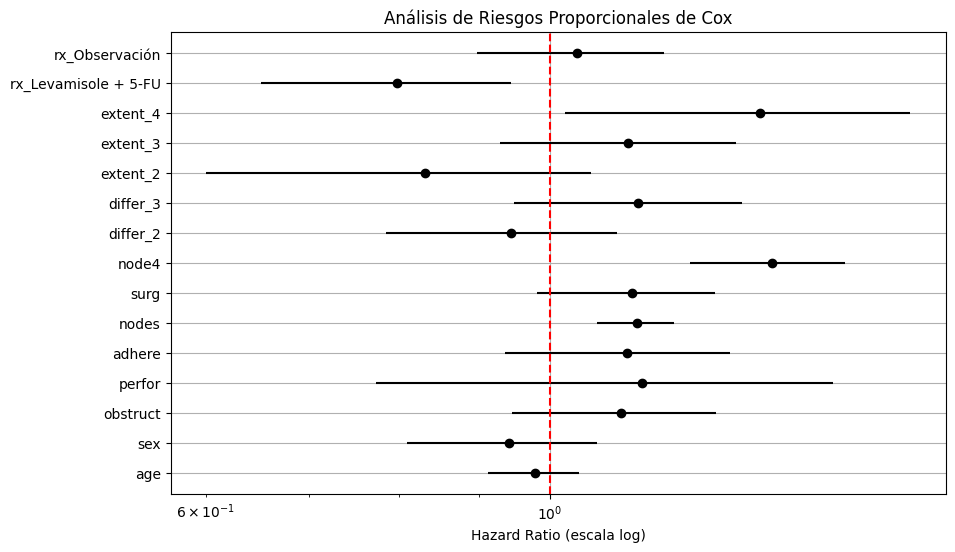

In [40]:


# ----------------------------------------------------------
# Ajustar modelo
# ----------------------------------------------------------
cph = CoxPHFitter(penalizer=0.5)
cph.fit(df_cox, duration_col='time', event_col='status')

# ----------------------------------------------------------
# Visualización correcta
# ----------------------------------------------------------
# Opción 1: Gráfico de coeficientes con intervalos de confianza
plt.figure(figsize=(10, 6))
cph.plot()
plt.title('Coeficientes del Modelo de Cox')
plt.show()



# Opción 3: Forest plot manual
plt.figure(figsize=(10, 6))
plt.errorbar(
    x=cph.hazard_ratios_,
    y=cph.params_.index,
    xerr=[cph.params_ - cph.confidence_intervals_['95% lower-bound'], cph.confidence_intervals_['95% upper-bound'] - cph.params_],
    fmt='o',
    color='black'
)
plt.axvline(x=1, color='red', linestyle='--')
plt.xscale('log')
plt.xlabel('Hazard Ratio (escala log)')
plt.title('Análisis de Riesgos Proporcionales de Cox')
plt.grid(True)
plt.show()